# Описание проекта

Даны пробы нефти в трёх регионах, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, оценить возможную прибыль и риски. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

Загрузим библиотеки, которые могут нам понадобиться для выполнения проекта.

In [1]:
import sklearn
import joblib
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
from scipy import stats as st
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import math

Сохраним число, которое послужит зерном для случайного состояния моделей. Также сохраним в переменной state случайное состояние для осуществления бутстрепа.

In [2]:
random = 12345
state = np.random.RandomState(random)

Загрузим данные. В коде мы будем помечать соответствующие массивы данных, срезы и показатели номером, соответствующим номеру в названии файла данных региона, но чтобы не возникло путаницы с числовым обозначением региона, сами регионы мы будем называть регионы А, В и С (номера файлов 0, 1 и 2 соответственно). 

In [3]:
df_raw0 = pd.read_csv('...')
df_raw1 = pd.read_csv('...')
df_raw2 = pd.read_csv('...')

In [4]:
df_raw0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные по региону А загружены, пропусков в них нет, типы данных подходящие в каждом столбце.

In [5]:
df_raw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные по региону В загружены, пропусков в них нет, типы данных подходят значениям в каждом столбце.

In [6]:
df_raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные по региону С загружены, пропусков в них нет, типы данных подходят значениям в каждом столбце.

Из того, что мы можем хотя бы частично проверить - адекватность данных в столбце object. Он содержит информацию о количестве нефти в месторождении. Посмотрим, нет ли среди них значений ниже ноля (сам ноль не является недопустимым значением, отсутствие ресурса в месторождении теоретически возможно, отрицательное его значения - нет). 

In [7]:
len(df_raw0.query('product < 0'))

0

In [8]:
len(df_raw1.query('product < 0'))

0

In [9]:
len(df_raw2.query('product < 0'))

0

Невозможных значений признака product не обнаружено.

Поскольку о пропусках и типах данных беспокоиться не стоит, а подробная проверка адекватности значений в столбцах f1, f2 и f3 невозможно из-за отсутствия информации о них со стороны заказчика, остается только проверить наличие дубликатов.  
Главное для нас - полные дубликаты строк. На всякий случай проверим также наличие дубликатов по наименованию объектов. Делаем это для лучшего понимания данных, удалять такие дубликаты не будем, поскольку, во-первых, могут существовать причины, известные заказчику, по которым у одного месторождения могут быть разные сочетания запаса нефти и факторов (например, оценка происходила на одном месторождении в разное время), во-вторых, это может быть ошибка внесения результата в базу данных (например, опечатка), которая для нашего дела не играет роли: мы все равно будем оценивать объект по сочетанию факторов, а столбец с id перед обученим модели мы удалим. 

In [12]:
df_raw0.duplicated().sum()

0

In [13]:
df_raw0['id'].duplicated().sum()

10

In [14]:
df_raw1.duplicated().sum()

0

In [15]:
df_raw1['id'].duplicated().sum()

4

In [16]:
df_raw2.duplicated().sum()

0

In [17]:
df_raw2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [18]:
df_raw2['id'].duplicated().sum()

4

Ни одного критически важного для нас полного дубликата строк не выявлено, а вот дубликаты названий есть каждом регионе. Будем просто иметь это в виду на случай возниковения проблем.

### Вывод

Данные загружены и проверены. Критических для нашей работы проблем с ними нет, можно приступать к обучению моделей.

# 2. Обучение и проверка модели

## Регион А

Данный этап работы предполагает обучение моделей для каждого региона с использованием информации обо всех имеющихся в регионах месторождениях. Начнем с региона А. Разобьем данные на обучающую и валидационную выборки, произведем масштабирование данных, обучим модель на 75% данных по месторождениям и проверим на 25%.

In [19]:
#разделение на признаки и цели
features0 = df_raw0.drop(['id', 'product'], axis = 1)
target0 = df_raw0['product']

#разбиение на обучающую и валидационную выборки
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
    features0, target0, 
    test_size = 0.25, random_state = random)

#масштабирование
numeric = ['f0', 'f1', 'f2']
scaler0 = StandardScaler()
scaler0.fit(features_train0[numeric])
features_train0.loc[:, numeric] = scaler0.transform(features_train0.loc[:,numeric])
features_valid0.loc[:, numeric] = scaler0.transform(features_valid0.loc[:,numeric])


model_0 = LinearRegression()
model_0.fit(features_train0, target_train0)
predicted_valid0 = model_0.predict(features_valid0)
mse0 = mean_squared_error(target_valid0, predicted_valid0)
rmse0 = mse0 ** 0.5
mae0 = mean_absolute_error(target_valid0, predicted_valid0)
est_mean_q0 = predicted_valid0.mean()
r2_0 = model_0.score(features_valid0, target_valid0) 
true_mean_q0 = target_valid0.mean()

print('Регион А')
print('')
print('RMSE:', rmse0)
print('MAE:', mae0)
print('R^2:', r2_0)
print('Предполагаемый средний запас сырья:', est_mean_q0)
print('Реальный средний запас сырья:', true_mean_q0)

Регион А

RMSE: 37.5794217150813
MAE: 30.919600777151313
R^2: 0.27994321524487786
Предполагаемый средний запас сырья: 92.59256778438038
Реальный средний запас сырья: 92.07859674082927


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/p

Проверим результат на адекватность: посчитаем среднее обучающей выборки и корень средней квадратической ошибки и сравним показатели. Посмотрим, насколько наша модель лучше способа, при котором мы бы оценивали целевой признак валидационной выборки, просто подставляя среднее, рассчитанное на основе имеющейся у нас обучающей выборки.

In [20]:
true_mean0 = target_train0.mean()
true_mean0

92.64046775305694

In [21]:
relevance_predictions0 = pd.Series(true_mean0, index = target_valid0.index)
relevance_rmse0 = mean_squared_error(target_valid0, relevance_predictions0) ** 0.5
relevance_rmse0

44.289591053907365

RMSE модели ниже RMSE по среднему, но ненамного. К сожалению, хоть модель и предсказывает запас сырья лучше, чем простое приравнивание прогноза к среднему, но несильно. О не самом высоком качестве предсказания так же говорит большое значение MAE и невысокое значение R-квадрат.

In [22]:
df_raw0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


## Регион В

Проделаем то же самое с данными по региону B.

In [23]:
#разделение на признаки и цели
features1 = df_raw1.drop(['id', 'product'], axis = 1)
target1 = df_raw1['product']

#разбиение на обучающую и валидационную выборки
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features1, target1, 
    test_size = 0.25, random_state = random)

#масштабирование
scaler1 = StandardScaler()
scaler1.fit(features_train1[numeric])
features_train1.loc[:, numeric] = scaler1.transform(features_train1.loc[:,numeric])
features_valid1.loc[:, numeric] = scaler1.transform(features_valid1.loc[:,numeric])


model_1 = LinearRegression()
model_1.fit(features_train1, target_train1)
predicted_valid1 = model_1.predict(features_valid1)
mse1 = mean_squared_error(target_valid1, predicted_valid1)
rmse1 = mse1 ** 0.5
mae1 = mean_absolute_error(target_valid1, predicted_valid1)
est_mean_q1 = predicted_valid1.mean()
r2_1 = model_1.score(features_valid1, target_valid1)
true_mean_q1 = target_valid1.mean()

print('Регион B')
print('')
print('RMSE:', rmse1)
print('MAE:', mae1)
print('R^2:', r2_1)
print('Предполагаемый средний запас сырья:', est_mean_q1)
print('Реальный средний запас сырья:', true_mean_q1)

Регион B

RMSE: 0.8930992867756158
MAE: 0.718766244212475
R^2: 0.9996233978805126
Предполагаемый средний запас сырья: 68.728546895446
Реальный средний запас сырья: 68.72313602435997


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/

In [24]:
train_mean1 = target_valid1.mean()
train_mean1

68.72313602435997

In [25]:
relevance_predictions1 = pd.Series(train_mean1, index = target_valid1.index)
relevance_rmse1 = mean_squared_error(target_valid1, relevance_predictions1) ** 0.5
relevance_rmse1

46.0212449226281

Ситуация с моделью для региона В гораздо лучше: RMSE модели намного меньше RMSE на основе подстановки среднего, метрики ошибок модели не превышают единицы, а R-квадрат очень близок к единице. Судя по этим показателям, модель для предсказания запасов в месторождениях региона В получилась удачной. 

## Регион С

In [26]:
#разделение на признаки и цели
features2 = df_raw2.drop(['id', 'product'], axis = 1)
target2 = df_raw2['product']

#разбиение на обучающую и валидационную выборки
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features2, target2, 
    test_size = 0.25, random_state = random)

#масштабирование
scaler2 = StandardScaler()
scaler2.fit(features_train2[numeric])
features_train2.loc[:, numeric] = scaler2.transform(features_train2.loc[:,numeric])
features_valid2.loc[:, numeric] = scaler2.transform(features_valid2.loc[:,numeric])


model_2 = LinearRegression()
model_2.fit(features_train2, target_train2)
predicted_valid2 = model_2.predict(features_valid2)
mse2 = mean_squared_error(target_valid2, predicted_valid2)
rmse2 = mse2 ** 0.5
mae2 = mean_absolute_error(target_valid2, predicted_valid2)
est_mean_q2 = predicted_valid2.mean()
r2_2 = model_2.score(features_valid2, target_valid2) 
true_mean_q2 = target_valid2.mean()

print('Регион С')
print('')
print('RMSE:', rmse2)
print('MAE:', mae2)
print('R^2:', r2_2)
print('Средний предполагаемый запас сырья:', est_mean_q2)
print('Реальный средний запас сырья:', true_mean_q2)

Регион С

RMSE: 40.02970873393434
MAE: 32.792652105481814
R^2: 0.20524758386040443
Средний предполагаемый запас сырья: 94.96504596800489
Реальный средний запас сырья: 94.88423280885438


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/

In [27]:
train_mean2 = target_valid2.mean()
train_mean2

94.88423280885438

In [28]:
relevance_predictions2 = pd.Series(train_mean2, index = target_valid2.index)
relevance_rmse2 = mean_squared_error(target_valid2, relevance_predictions2) ** 0.5
relevance_rmse2

44.902084376898294

К сожалению, модель для предсказания запасов региона С также не сильно обходит простую подстановку среднего обучающей выборки. Результаты даже немного хуже, чем в случае с регионом А.

Косвенным подтверждением качества моделей служат еще и расхождения в средних значениях запасов валидационных выборок и предсказаний моделей. В случае с регионами А и С расхождения уже в десятых долях, что, учитывая единицы измерения, означает разницу в сотни баррелей. В случае с моделью региона В среднее валидационной выборки удалось предсказать с точностью до пятидесяти баррелей. 

Тем не менее, во всех регионах модели прошли проверку на адекватность: во всех случаях для предсказания лучше использовать модели, чем среднее значение запасов обучающих выборок. 

## Сопоставление средних

In [29]:
target0.mean()

92.50000000000001

In [30]:
target1.mean()

68.82500000000002

In [31]:
target2.mean()

95.00000000000004

Text(0.5, 1.0, 'Total Mean Quantity')

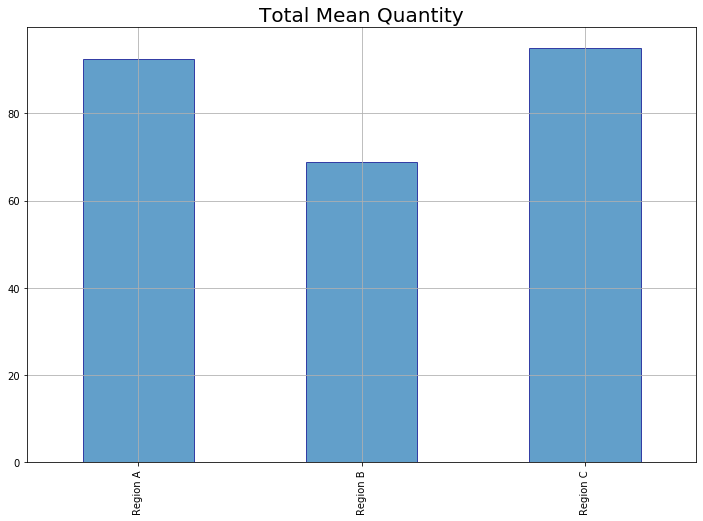

In [32]:
total_means = [target0.mean(), target1.mean(), target2.mean()]
total_means_regions = ['Region А','Region B','Region C']
total_means_df = pd.DataFrame(index = total_means_regions, data = total_means, columns = ['total_mean_quantity'])



total_means_df.plot( kind = 'bar', figsize = (12,8),
       alpha = 0.7, edgecolor = 'darkblue', grid = True, legend = False )
plt.title('Total Mean Quantity', fontsize = 20)

Довольно интересным наблюдением, которое пригодится нам в дальнейшем, является то, что если давать оценку регионам только по средним, регион В, по большому счету, сильно позади примерно равных по общим запасам регионов А и С. Количество объектов в каждом регионе одинаково, следовательно, и по совокупному запасу нефти регион В отстает.  
Однако принимать решение на основании только среднего запаса было бы ошибкой, поскольку, во-первых, не учитывается распределение (в А и С запасы распределены менее равномерно, чем в В), во-вторых, мы максимизируем прибыль при заданных бюджетных ограничениях. Для этого нам придется рассчитать дополнительные показатели.

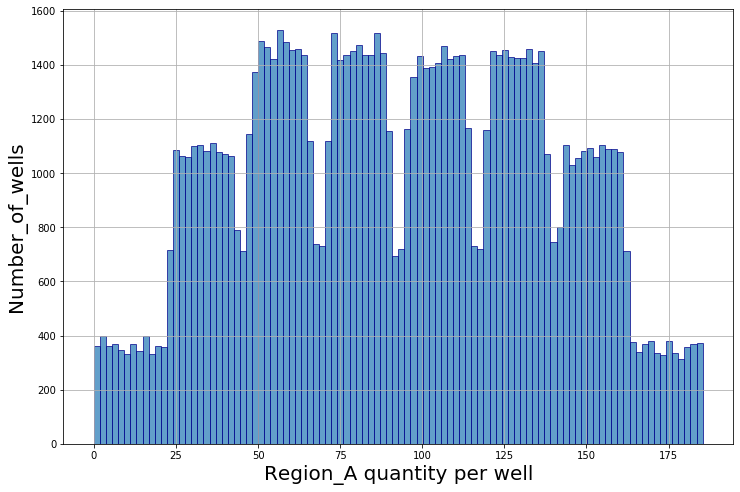

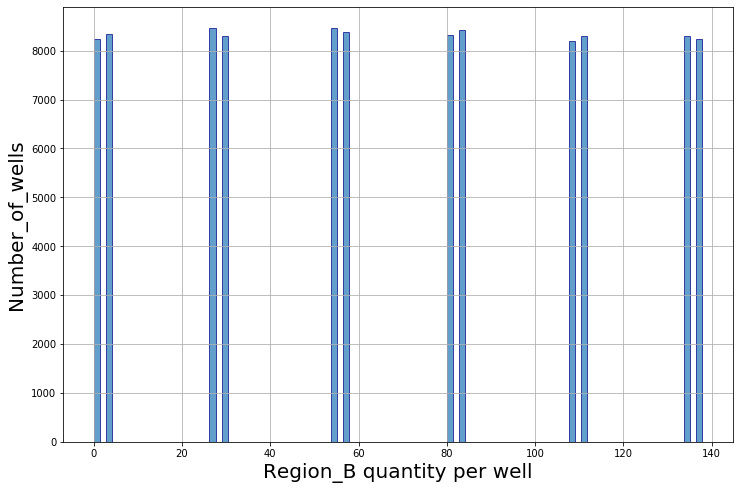

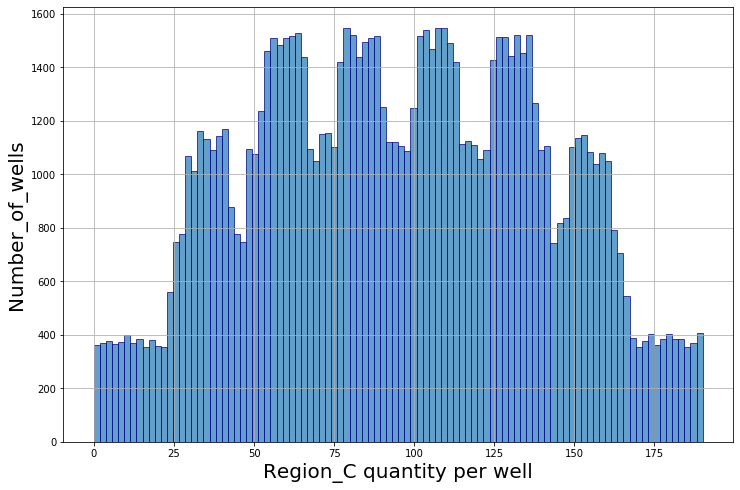

In [33]:
total_quantities_dict = {'Region_A': target0, 'Region_B':target1, 'Region_C':target2}
total_quantities = ['Region_A', 'Region_B', 'Region_C']
for i in total_quantities:
    total_quantities_dict[i].hist(bins = 100, figsize = (12,8),
           alpha = 0.7, edgecolor = 'darkblue', grid = True)
    plt.xlabel('%s quantity per well' % i, fontsize = 20)
    plt.ylabel('Number_of_wells', fontsize = 20)
    plt.show()

### Вывод

Все модели прошли тест на адекватность. Модели регионов А и С показали сравнительно слабые результаты, модель для региона В показала превосходные результаты на валидационной выборке. При этом замечено, что по средним запасам нефти регион В ощутимо уступает регионам А и С.

# 3. Подготовка к расчёту прибыли

Расчитаем и/или сохраним в переменных следующие показатели: бюджет, затраты на одну скважину (бурение), количество скважин, которые нам позволяет пробурить бюджет, количество исследуемых во время разведки месторождений, цену за баррель, минимальное количество баррелей нефти в месторождении, достаточное для безубыточности разработки.

Важное уточнение: как сообщил нам представитель заказчика, под прибылью с барреля подразумевался доход с барреля. Что логично, учитывая, что нам надо расчитать прибыль, а не просто пересчитать количество баррелей.

In [34]:
budget = 10000000000
cost_on_well = 50000000
number_of_wells = budget / cost_on_well
price_of_barrel = 4500
number_of_scouts = 500
quantity_of_zero_loss_on_well = cost_on_well / price_of_barrel


In [35]:
quantity_of_zero_loss_on_well

11111.111111111111

Количество баррелей, необходимое для того, чтобы окупить бурение скважины - 11 тысяч 112 баррелей нефти. Если в месторождении меньший объем ресурса, его разработка убыточна.

In [36]:
number_of_wells

200.0

Количество скважин, которое мы можем пробурить, не выходя из бюджета - 200 скважин.

Определим функцию, которая принимает на вход количество (запасы нефти в тысячах баррелей) и выдает прибыль. Важно уточнить два аспекта:  

1) модели обучены прогнозировать запасы на тысячах баррелей и выдают они предсказания о запасах в тысячах баррелей. Цена нам дана за баррель. Поэтому в формуле расчета прибыли в функции домножим принимаемое количество на тысячу.  

2) по описанной заказчиком процедуре разработки регионов прибыль считается как совокупная прибыль отобранных месторождений, то есть для двухсот выбранных в результате разведки месторождений, а не для каждого по отдельности. Поэтому количество, которое мы будем передавать функции - совокупный объем нефти в отобранных месторождениях, а вычитается не затраты на разработку вышки, а бюджет. 

In [37]:
def get_profit(quantity):
    profit = (price_of_barrel * quantity * 1000) - budget
    return profit

Мы владеем данными, необходимыми для следующего этапа.  
Следующий этап подразумевает многократную симуляцию разведки и разработки региона. Она подразумевает, исходя из сообщенной заказчиком процедуры, что:
- в регионе проводится выборочная разведка 500 случайно выбранных месторождений
- по факторам этих пятисот месторождений, определенным в ходе разведки, модель соответствующего региона предсказывает предполагаемые объемы нефти в каждом из разведанных месторождений
- из пятисот разведанных месторождений отбираются 200 (количество получено на основе расчета выше) с наибольшими запасами нефти
- Производится разработка этих месторождений, доход от них считается перемножением цены за баррель и объема нефти в выбранных месторождениях
- Прибыль считается вычитанием бюджета (суммарных трат) из совокупного дохода с двухсот скважин

Однако проведя только одну подобную симуляцию, мы никак не сможем оценить риски убытков бурения в регионе, а также оценить, с какой вероятностью предполагаемая прибыль совпадет с той, которую мы получим в результате реальной разработки региона. Поэтому мы применим бутстреп: повторим симуляцию многократно (по требованию заказчика - 1000 раз).  

На основе тысячи полученных показателей предполагаемой прибыли мы построим распределение прибылей, которое позволит нам посчитать среднюю предполагаемую прибыль, доверительный интервал, с помощью которого мы сможем оценить, в каком диапазоне мы получим прибыль с 95% вероятностью, а также сможем оценить риски.  

Риски мы оценим, определив квантиль, соответствующий нулевой прибыли в полученном нами распределении прибылей. Он и будет процентным отображением вероятности пробурить скважины так, чтобы уйти в минус. Если он будет превышать 2.5%, мы откажемся от разработки региона.

# 4. Расчёт прибыли и рисков 

Процедуру бутстрепа мы будем применять одинаково ко всем регионам, отличаться будут только признаки месторождений, из которых будем создавать подвыборки (массивы features для каждого из регионов) и модели, которые также у каждого региона своя.   
Определим функцию, которая будет принимать на вход уникальные для каждого региона модели и массивы с данными обо всех месторождениях в регионе (features и target), а также количество генерируемых подвыборок. Последний аргумент будет одинаков для всех регионов - запрашиваемые заказчиком 1000 подвыборок - но для большей гибкости на случай дальнейшего изменения требований заказчиком оставим этот параметр в качестве передаваемого аргумента.

In [38]:
def bootstrapping(features_x, target_x, model_x, n_subsamples):
    profit_col = []
    for i in range(n_subsamples):
        subsample = features_x.sample(n = number_of_scouts,
                                            replace = True,
                                            random_state = state)
        predicted_quantity = model_x.predict(subsample)
        target_wells_quantity = (pd.Series(predicted_quantity)
                                 .sort_values(ascending = False)
                                 .head(int(number_of_wells)))
        target_wells_real_quantity = target_x[target_wells_quantity.index]
        target_wells_total_quantity = target_wells_real_quantity.sum()
        profit = get_profit(target_wells_total_quantity)
        profit_col.append(profit)
        
    profit_distr = pd.Series(profit_col)
    mean_estimated_profit = profit_distr.mean()
    lower_profit = profit_distr.quantile(0.025)
    upper_profit = profit_distr.quantile(0.975)
    risk_of_loss = st.percentileofscore(profit_distr, 0)
    
    return profit_distr, mean_estimated_profit, lower_profit, upper_profit, risk_of_loss


Применим бутстреп для региона А.

In [39]:
profit_distr0, mean_estimated_profit0, lower_profit0, upper_profit0, risk_of_loss0 = bootstrapping(features0, target0, model_0, 1000)
profit_distr0

0      7.183315e+10
1      7.501699e+10
2      7.347040e+10
3      7.402109e+10
4      7.483478e+10
           ...     
995    7.080436e+10
996    7.131723e+10
997    7.396234e+10
998    7.268685e+10
999    7.343051e+10
Length: 1000, dtype: float64

In [40]:
risk_of_loss0

0.0

Применим тот же метод для региона B.

In [41]:
profit_distr1, mean_estimated_profit1, lower_profit1, upper_profit1, risk_of_loss1 = bootstrapping(features1, target1, model_1, 1000)

Сделаем то же самое с регионом С.

In [42]:
profit_distr2, mean_estimated_profit2, lower_profit2, upper_profit2, risk_of_loss2 = bootstrapping(features2, target2, model_2, 1000)

Сведем получившиеся результаты в таблицу (таблица представляет наши основные выводы, поэтому оформим ее наглядно, подпишем столбцы подробно и по-русски).

In [43]:
regions = ['Регион A', 'Регион B', 'Регион C']
mean_profit = [mean_estimated_profit0, mean_estimated_profit1, mean_estimated_profit2]
lower_profit = [lower_profit0, lower_profit1, lower_profit2]
upper_profit = [upper_profit0, upper_profit1, upper_profit2]
risk_of_loss = [risk_of_loss0, risk_of_loss1, risk_of_loss2]

results_dict = {'средняя предполагаемая прибыль (млрд руб.)': mean_profit, 
                'нижний доверительный предел прибыли (млрд руб.)': lower_profit,
                'верхний доверительный предел прибыли (млрд руб.)': upper_profit, 
                'риск убытков (%)': risk_of_loss}
results = pd.DataFrame(index = regions, data = results_dict)

results['средняя предполагаемая прибыль (млрд руб.)'] = (round(
    results['средняя предполагаемая прибыль (млрд руб.)'] / 1000000000, 2))
results['нижний доверительный предел прибыли (млрд руб.)'] = (round(
    results['нижний доверительный предел прибыли (млрд руб.)'] / 1000000000, 2))
results['верхний доверительный предел прибыли (млрд руб.)'] = (round(
    results['верхний доверительный предел прибыли (млрд руб.)'] / 1000000000, 2))

results

,средняя предполагаемая прибыль (млрд руб.),нижний доверительный предел прибыли (млрд руб.),верхний доверительный предел прибыли (млрд руб.),риск убытков (%)
Регион A,72.52,67.75,76.77,0.0
Регион B,50.67,45.99,55.14,0.0
Регион C,71.84,67.65,76.17,0.0


Для наглядности подготовим для заказчика визуализацию распределений потенциальных прибылей с нанесением основной информации.

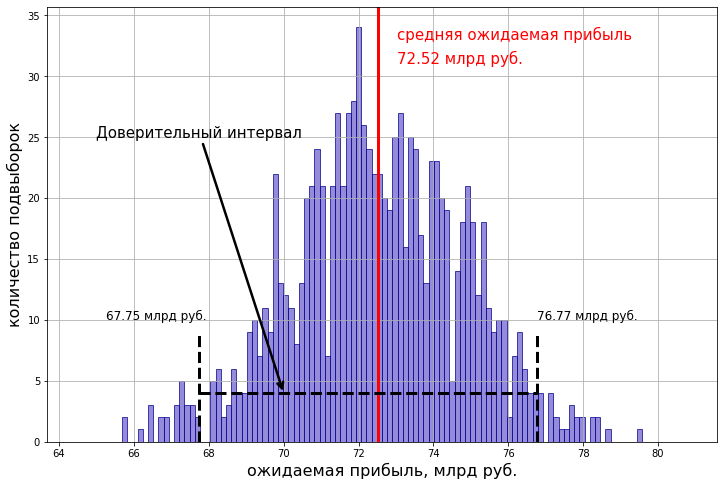

In [44]:
profit_distr0_bln = profit_distr0 / 1000000000
mean0 = mean_estimated_profit0 / 1000000000
lower0 = lower_profit0 / 1000000000
upper0 = upper_profit0 / 1000000000


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.grid(b=True, which = 'major' )
hist = (profit_distr0_bln.plot(y = 'total_sales', kind = 'hist', bins = 100, figsize = (12,8), 
       alpha = 0.7, color = 'slateblue', edgecolor = 'darkblue', grid = True))
plt.xlabel('ожидаемая прибыль, млрд руб.', fontsize = 16)
plt.ylabel('количество подвыборок', fontsize = 16)
ax.set_xlim(profit_distr0_bln.min()-2, profit_distr0_bln.max()+2)

plt.axvline(x=mean0, linestyle = '-', linewidth = 3, color = 'red')
mean_text1 = plt.text(mean0 + 0.5, 33, 'средняя ожидаемая прибыль', color = 'red', size = 15)
mean_text2 = plt.text(mean0 + 0.5, 31, '%s млрд руб.' % round(mean0,2), color = 'red', size = 15) 
plt.axvline(x=lower0, ymax = 0.25, linestyle = '--', linewidth = 3, color = 'black')
lower_text = plt.text(lower0 - 2.5, 10, '%s млрд руб.' % round(lower0,2), size = 12)
plt.axvline(x=upper0, ymax = 0.25, linestyle = '--', linewidth = 3, color = 'black')
upper_text = plt.text(upper0 , 10, '%s млрд руб.' % round(upper0,2), size = 12)
plt.axhline(y=4, 
            xmin = (lower0-(profit_distr0_bln.min()-2))/((profit_distr0_bln.max()+2)-(profit_distr0_bln.min()-2)), 
            xmax = (upper0-(profit_distr0_bln.min()-2))/((profit_distr0_bln.max()+2)-(profit_distr0_bln.min()-2)), 
            linestyle = '--', linewidth = 3, color = 'black')
plt.annotate("Доверительный интервал", xy=(70,4), xytext=(65,25),fontsize=15, arrowprops = dict(arrowstyle = '->',
                                                                                                  color = 'black', 
                                                                                                  linewidth = 2.5))

plt.show()



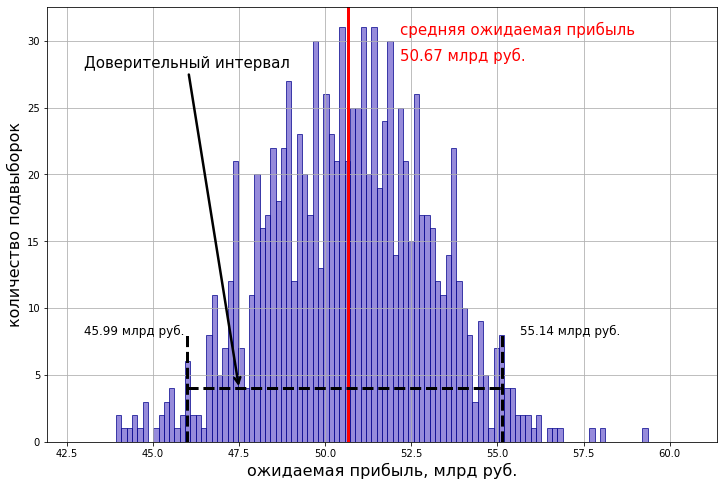

In [45]:
profit_distr1_bln = profit_distr1 / 1000000000
mean1 = mean_estimated_profit1 / 1000000000
lower1 = lower_profit1 / 1000000000
upper1 = upper_profit1 / 1000000000


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.grid(b=True, which = 'major' )
hist = (profit_distr1_bln.plot(y = 'total_sales', kind = 'hist', bins = 100, figsize = (12,8), 
       alpha = 0.7, color = 'slateblue', edgecolor = 'darkblue', grid = True))
plt.xlabel('ожидаемая прибыль, млрд руб.', fontsize = 16)
plt.ylabel('количество подвыборок', fontsize = 16)
ax.set_xlim(profit_distr1_bln.min()-2, profit_distr1_bln.max()+2)

plt.axvline(x=mean1, linestyle = '-', linewidth = 3, color = 'red')
mean_text1 = plt.text(mean1 + 1.5, 30.5, 'средняя ожидаемая прибыль', color = 'red', size = 15)
mean_text2 = plt.text(mean1 + 1.5, 28.5, '%s млрд руб.' % round(mean1,2), color = 'red', size = 15) 
plt.axvline(x=lower1, ymax = 0.25, linestyle = '--', linewidth = 3, color = 'black')
lower_text = plt.text(lower1 - 3, 8, '%s млрд руб.' % round(lower1,2), size = 12)
plt.axvline(x=upper1, ymax = 0.25, linestyle = '--', linewidth = 3, color = 'black')
upper_text = plt.text(upper1 + 0.5, 8, '%s млрд руб.' % round(upper1,2), size = 12)
plt.axhline(y=4, 
            xmin = (lower1-(profit_distr1_bln.min()-2))/((profit_distr1_bln.max()+2)-(profit_distr1_bln.min()-2)), 
            xmax = (upper1-(profit_distr1_bln.min()-2))/((profit_distr1_bln.max()+2)-(profit_distr1_bln.min()-2)), 
            linestyle = '--', linewidth = 3, color = 'black')
plt.annotate("Доверительный интервал", xy=(47.5,4), xytext=(43,28),fontsize=15, arrowprops = dict(arrowstyle = '->',
                                                                                                  color = 'black', 
                                                                                                  linewidth = 2.5))

plt.show()



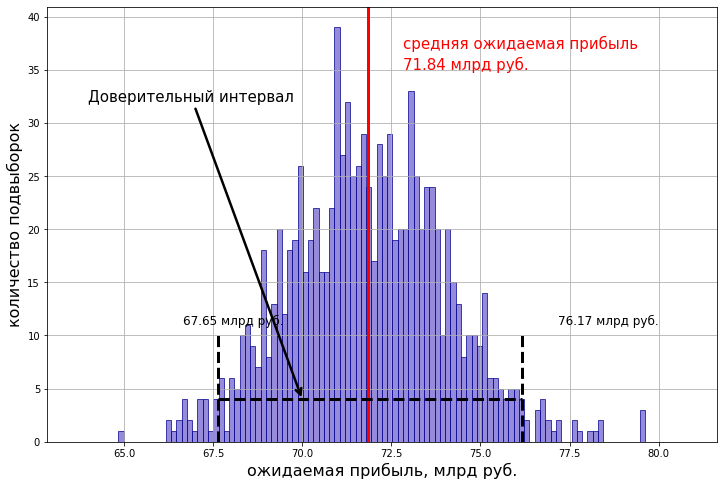

In [46]:
profit_distr2_bln = profit_distr2 / 1000000000
mean2 = mean_estimated_profit2 / 1000000000
lower2 = lower_profit2 / 1000000000
upper2 = upper_profit2 / 1000000000


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.grid(b=True, which = 'major' )
hist = (profit_distr2_bln.plot(y = 'total_sales', kind = 'hist', bins = 100, figsize = (12,8), 
       alpha = 0.7, color = 'slateblue', edgecolor = 'darkblue', grid = True))
plt.xlabel('ожидаемая прибыль, млрд руб.', fontsize = 16)
plt.ylabel('количество подвыборок', fontsize = 16)
ax.set_xlim(profit_distr2_bln.min()-2, profit_distr2_bln.max()+2)

plt.axvline(x=mean2, linestyle = '-', linewidth = 3, color = 'red')
mean_text1 = plt.text(mean2 + 1, 37, 'средняя ожидаемая прибыль', color = 'red', size = 15)
mean_text2 = plt.text(mean2 + 1, 35, '%s млрд руб.' % round(mean2,2), color = 'red', size = 15) 
plt.axvline(x=lower2, ymax = 0.25, linestyle = '--', linewidth = 3, color = 'black')
lower_text = plt.text(lower2 - 1, 11, '%s млрд руб.' % round(lower2,2), size = 12)
plt.axvline(x=upper2, ymax = 0.25, linestyle = '--', linewidth = 3, color = 'black')
upper_text = plt.text(upper2 + 1, 11, '%s млрд руб.' % round(upper2,2), size = 12)
plt.axhline(y=4, 
            xmin = (lower2-(profit_distr2_bln.min()-2))/((profit_distr2_bln.max()+2)-(profit_distr2_bln.min()-2)), 
            xmax = (upper2-(profit_distr2_bln.min()-2))/((profit_distr2_bln.max()+2)-(profit_distr2_bln.min()-2)), 
            linestyle = '--', linewidth = 3, color = 'black')
plt.annotate("Доверительный интервал", xy=(70,4), xytext=(64,32),fontsize=15, arrowprops = dict(arrowstyle = '->',
                                                                                                  color = 'black', 
                                                                                                  linewidth = 2.5))

plt.show()



## Общий вывод

1) Регион А, немного уступая региону С по показателю средних запасов, с небольшим отрывом лидирует по показателю средней предполагаемой прибыли. Регион В, уступающий остальным по показателю средних запасов нефти, обладает наименьшей средней предполагаемой прибылью среди всех.  
2) Согласно сопоставлению доверительных интервалов, с 95% вероятностью добыча нефти в регионе А принесет прибыли от 67.75 до 76.77 млрд руб., добыча в регионе С с той же вероятностью не намного уступает, доверительные пределы не намного доверительных пределов распределения прибыли в регионе А.  
3) Риски убытков у всех регионов одинаковы и равны нулю.

На осонвании большего показателя средней потенциальной прибыли и более высоких значений доверительных пределов, подразумевающих, что 95% вероятностью заказчик получит большую прибыль, чем в других регионах, можно  __рекомендовать к разработке регион А (первый регион, регион_0)__   

## Комментарий к результатам

Нулевые значения риска убытков скорее всего обусловлены, во-первых, очень низким количеством объектов с недостаточным количеством нефти в исходных выборках, во-вторых, большим количеством объектов с сильно превышающими необходимый объемами нефти, компенсирующих убыточные при построении подвыборок.

In [47]:
df_raw0.query('product*1000 < @quantity_of_zero_loss_on_well')['product'].count() / df_raw0['product'].count()

0.02171

In [48]:
df_raw1.query('product*1000 < @quantity_of_zero_loss_on_well')['product'].count() / df_raw1['product'].count()

0.16572

In [49]:
df_raw2.query('product*1000 < @quantity_of_zero_loss_on_well')['product'].count() / df_raw2['product'].count()

0.02163

Тем не менее, вероятность того, что разведка могла напасть на 500 месторождений с нулевыми запасами, хоть и крайне маленькая, но существует, чего в результате будстрепа выявлено не было.

In [50]:
df_raw1['profit'] = (df_raw1['product'] * 1000) - cost_on_well
df_raw1.sort_values(by = 'product').head(500)

,id,f0,f1,f2,product,profit
49999,Wzexe,9.390544,-4.724610,-0.005476,0.0,-50000000.0
52336,7muuQ,13.714032,-1.922120,0.003622,0.0,-50000000.0
52332,ittDY,4.315195,-7.519752,-0.002357,0.0,-50000000.0
52320,dSHsg,15.805817,-8.547300,-0.002974,0.0,-50000000.0
52318,ezUSb,11.726332,-6.828102,-0.007404,0.0,-50000000.0
...,...,...,...,...,...,...
56344,IYQxa,5.900808,-0.051944,0.003844,0.0,-50000000.0
56326,6PDxy,11.152410,1.067144,-0.006977,0.0,-50000000.0
56321,4EEk9,7.699825,-3.425707,0.002723,0.0,-50000000.0
56319,b2W51,4.421972,-0.205219,-0.001223,0.0,-50000000.0


На более точный анализ рисков может повлиять увеличение количества подвыборок. Размер подвыборок при этом скорее уменьшит вероятность получить риск убытка более нуля, поскольку с увеличением размера подвыборки увеличится шанс того, что в нее войдут прибыльные месторождения, которые скомпенсируют потери от убыточных объектов.  
Серьезное увеличение количества подвыборок, в свою очередь, затребует больших вычислительных мощностей. Но главное - это противоречит условиям задачи, поставленной заказчиком. Поэтому мы продалжаем рекомендовать заказчику регион А.